## **Model Training**

A dedicated notebook for all model training, tuning, and evaluating factors for our model.

In [209]:
# Basic Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Modeling
from sklearn.linear_model import LogisticRegression

# Processing + Diagnostics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [210]:
# connecting to db to query it

path = '/Users/Marcy_Student/Desktop/Marcy-Modules/CID/CID_data-slayer-corps/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [211]:
query = """
SELECT borough,
e.school_name,
metric_value_postsecondary_enrollment_6_months AS postsec_enroll_6mo, 
economic_need_index AS eni_rate,
percent_temp_housing AS pct_temp_housing,
metric_value_4yr_ccr_all_students AS ccr_rate,
family_involvement_pct_positive, 
avg_student_attendance
FROM dim_location l
JOIN dim_environment e
ON e.DBN = l.DBN
JOIN fact_school_outcomes f
ON e.DBN = f.DBN
"""

df = pd.read_sql_query(query, conn)
df

,borough,school_name,postsec_enroll_6mo,eni_rate,pct_temp_housing,ccr_rate,family_involvement_pct_positive,avg_student_attendance
0,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
1,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
2,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
3,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
4,Manhattan,University Neighborhood High School,0.839,0.719,0.097,77.1,0.82,0.915
...,...,...,...,...,...,...,...,...
2019,Bronx,Bronx Preparatory Charter School,0.722,0.912,0.097,NaN,NaN,0.847
2020,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934
2021,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934
2022,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934


## **Step 1: Preprocessing**

- Missing values

- Handle outliers

- Handle Distribution

- Creating Binary Column (For Logistic)

In [212]:
# missing values
display(df.isna().sum())

# ccr_rate, eni_rate have NAs. We will drop them.

df1 = df[['ccr_rate', 'eni_rate', 'pct_temp_housing', 'avg_student_attendance']].dropna()
display(df1.isna().sum())
display(df1.shape)

borough                              0
school_name                          0
postsec_enroll_6mo                 128
eni_rate                           268
pct_temp_housing                     0
ccr_rate                           364
family_involvement_pct_positive    216
avg_student_attendance              44
dtype: int64

ccr_rate                  0
eni_rate                  0
pct_temp_housing          0
avg_student_attendance    0
dtype: int64

(1408, 4)

***

### Quick look at data

<Axes: xlabel='eni_rate', ylabel='ccr_rate'>

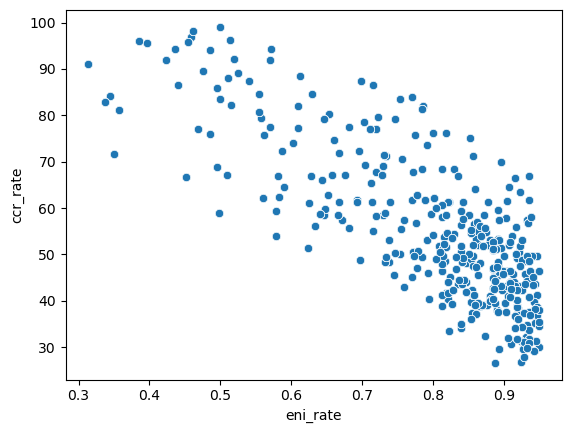

In [213]:
sns.scatterplot(df1, x='eni_rate', y='ccr_rate')

In [214]:
# outliers

col1 = ['ccr_rate', 'eni_rate']

for c in col1:
    print(f'For {c} ---> Min: {df1[c].min()} ----- Max: {df1[c].max()}')

# need to make ccr_rate between 0 and 1
print('==============================================================')
df1['ccr_rate'] = df1['ccr_rate'] / 100
df1

For ccr_rate ---> Min: 26.6 ----- Max: 99.1
For eni_rate ---> Min: 0.314 ----- Max: 0.95


,ccr_rate,eni_rate,pct_temp_housing,avg_student_attendance
0,0.540,0.911,0.190,0.818
1,0.540,0.911,0.190,0.818
2,0.540,0.911,0.190,0.818
3,0.540,0.911,0.190,0.818
4,0.771,0.719,0.097,0.915
...,...,...,...,...
1687,0.672,0.728,0.063,0.913
1688,0.298,0.933,0.315,0.821
1689,0.298,0.933,0.315,0.821
1690,0.298,0.933,0.315,0.821


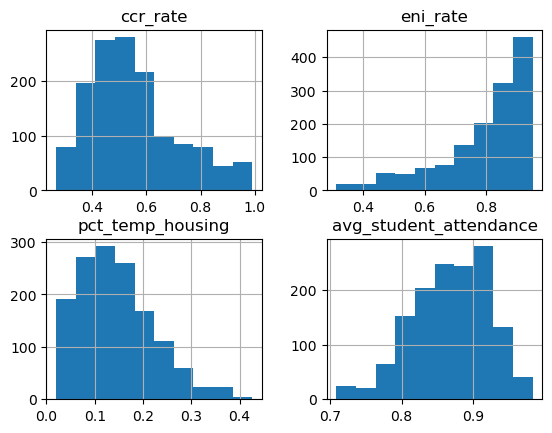

In [ ]:
# distribution
df1.hist() 

# we'll likely need to make eni more normal.
# let's use logit eni_rate, since it's heavily left-skewed

# logit
# Using a small epsilon (0.001) to avoid division by zero
epsilon = 0.001
df1['logit_eni'] = np.log((df1['eni_rate'] + epsilon) / (1 - df1['eni_rate'] + epsilon))


# for ccr_rate and pct_temp_housing, we'll simply square root (since they're not terribly skewed)
df1['sqrt_ccr_rate'] = np.sqrt(df1['ccr_rate'])
df1['sqrt_pct_temp_housing'] = np.sqrt(df1['pct_temp_housing'])
df1['sqrt_avg_student_attendance'] = np.sqrt(df1['avg_student_attendance'])

array([[<Axes: title={'center': 'sqrt_ccr_rate'}>,
        <Axes: title={'center': 'logit_eni'}>],
       [<Axes: title={'center': 'sqrt_pct_temp_housing'}>,
        <Axes: title={'center': 'sqrt_avg_student_attendance'}>]],
      dtype=object)

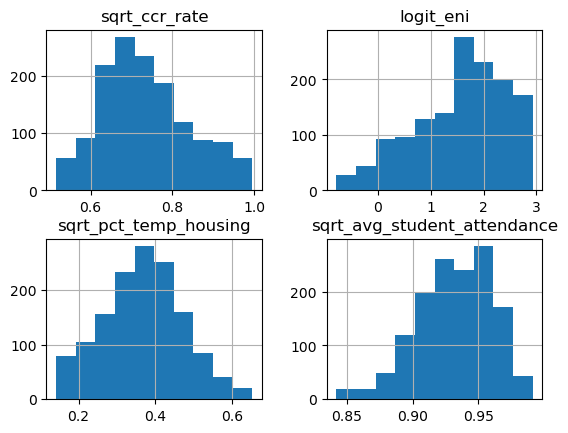

In [224]:
df1[['sqrt_ccr_rate', 'logit_eni', 'sqrt_pct_temp_housing', 'sqrt_avg_student_attendance']].hist()

In [225]:
# Creating Binary
df1['is_high_ccr'] = (df1['ccr_rate'] >= (np.quantile(df1['ccr_rate'], 0.75))).astype(int)
df1['is_high_ccr'].value_counts()

is_high_ccr
0    1056
1     352
Name: count, dtype: int64

#### **Important to note here**

This changes coefficient interpretation. +1 unit increase increases by sqrt/logit.

***

## **Train-Test Split, Constant, and Inputting to Model**

### **Linear Regression (OLS)**

Using multiple variables to test variance of factors.

In [230]:
# Our variables
X1 = df1[['logit_eni', 'sqrt_avg_student_attendance']]
y1 = df1['sqrt_ccr_rate']

# Split dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Add constant
X1_train = sm.add_constant(X1_train) 
X1_test = sm.add_constant(X1_test)

# Train the model
model1 = sm.OLS(y1, X1)
results = model1.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          sqrt_ccr_rate   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          9.830e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):                        0.00
Time:                        16:05:14   Log-Likelihood:                          1903.8
No. Observations:                1408   AIC:                                     -3804.
Df Residuals:                    1406   BIC:                                     -3793.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
logit_eni                      -0.0779      0.002    -41.428      0.000      -0.082      -0.074
sqrt_avg_student_attendance     0.9189      0.004    256.688      0.000       0.912       0.926
==============================================================================
Omnibus:                        3.985   Durbin-Watson:                   0.380
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.468
Skew:                          -0.043   Prob(JB):                        0.177
Kurtosis:                       2.773   Cond. No.                         4.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

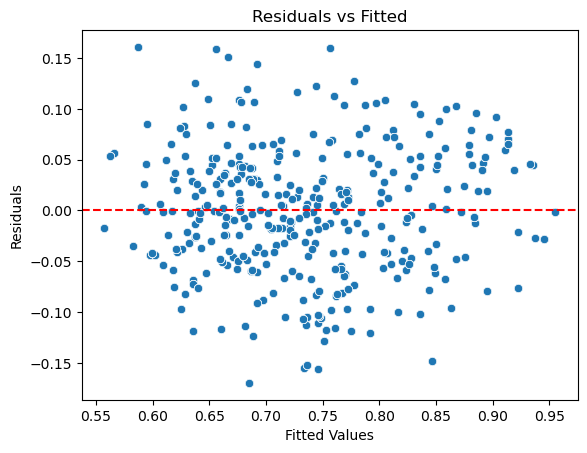

In [227]:
# Looking at Residuals
residuals = results.resid
fitted = results.fittedvalues

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

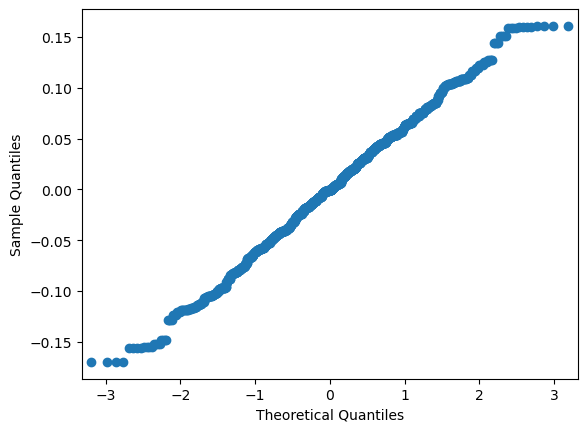

In [228]:
# Q-Q Plot
sm.qqplot(residuals)
plt.show()

In [229]:
# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

print(vif_data)

                       feature      VIF
0                    logit_eni  3.99685
1  sqrt_avg_student_attendance  3.99685


### **Logistic Model**

For Logistic, the binary y will represent high ccr past the 75th percentile.

In [231]:
# Our variables
X2 = df1[['logit_eni', 'sqrt_avg_student_attendance']] # Features
y2 = df1['is_high_ccr'] # Target variable (0 or 1)

# Split dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Add constant
X2_train = sm.add_constant(X2_train) 
X2_test = sm.add_constant(X2_test)

# Train the model
model2 = LogisticRegression(class_weight='balanced')     # balanced to pay extra attention to the minority group (high ccr)
model2.fit(X2_train, y2_train)

# Make predictions
y2_pred = model2.predict(X2_test)

# Evaluate
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print("Classification Report:\n", classification_report(y2_test, y2_pred, target_names=['Low/Med CCR (0)', 'High CCR (1)']))


Accuracy: 0.8439716312056738
Classification Report:
                  precision    recall  f1-score   support

Low/Med CCR (0)       0.95      0.84      0.89       216
   High CCR (1)       0.62      0.85      0.72        66

       accuracy                           0.84       282
      macro avg       0.79      0.85      0.81       282
   weighted avg       0.87      0.84      0.85       282



- Interesting note of precision for 1, telling us that it correctly guessed high CCR schools 62% of the time

- Also having a recall of 83% for 1, telling us that percent amount was actually found.
    - conversely, it missed 17% of high CCR schools.

### **Let's take a deeper look at the hits and misses**

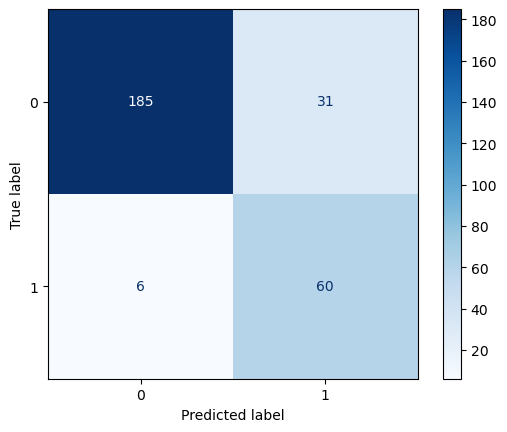

In [223]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')